### http://blog.drivendata.org/2016/12/23/dengue-benchmark/ 

### https://shaulab.github.io/DrivenData/DengAI/Benchmark.html

In [10]:

%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

In [5]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [6]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [7]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

In [10]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
dtype: bool

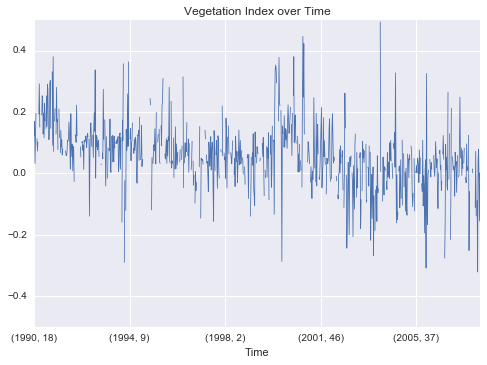

In [21]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [22]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [23]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.1805555556
var : 2640.04543969

Iquitos
mean:  7.56538461538
var : 115.895523937


array([<matplotlib.axes._subplots.AxesSubplot object at 0x114776048>], dtype=object)

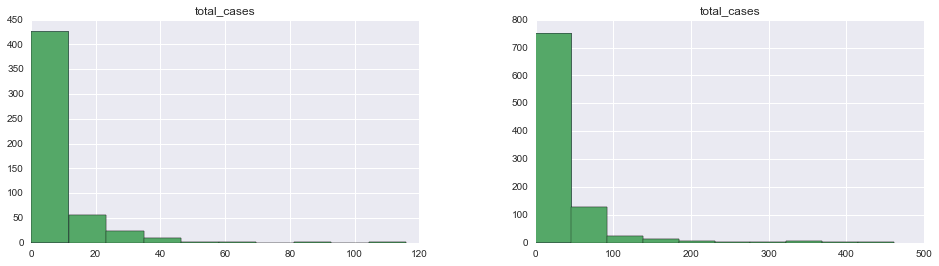

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
iq_train_labels.hist(ax=ax1)
sj_train_labels.hist(ax=ax2)
ax1.set_title('Iquitos', fontsize=18)
ax2.set_title('San Juan', fontsize=18)
iq_train_labels.hist(ax=ax1)
sj_train_labels.hist(ax=ax2)

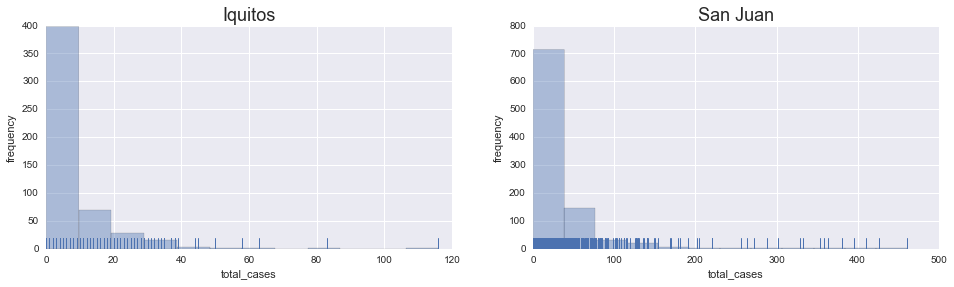

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(iq_train_labels.total_cases, bins=12, kde=False, rug=True, ax=ax1)
sns.distplot(sj_train_labels.total_cases, bins=12, kde=False, rug=True, ax=ax2)
ax1.set_title('Iquitos', fontsize=18)
ax2.set_title('San Juan', fontsize=18)
ax1.set(ylabel='frequency')
ax2.set(ylabel='frequency')

In [29]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [30]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

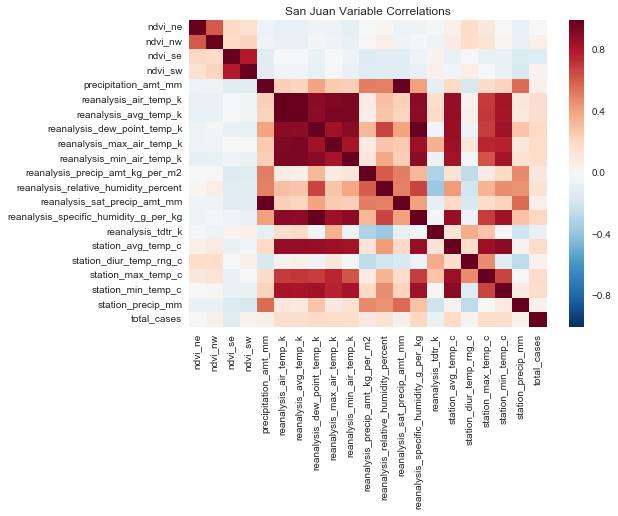

In [31]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

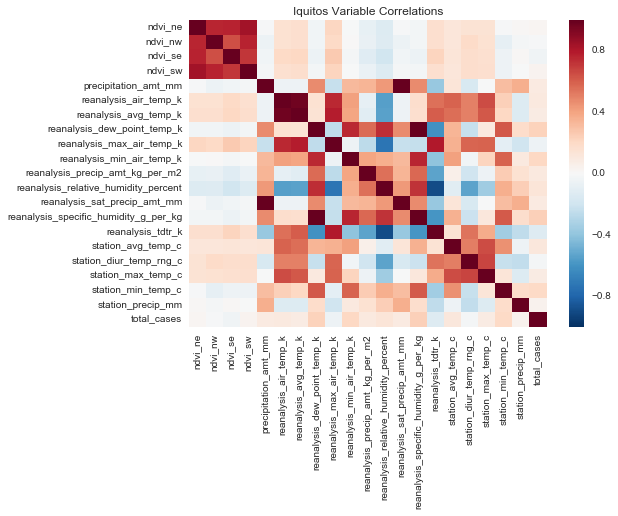

In [32]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

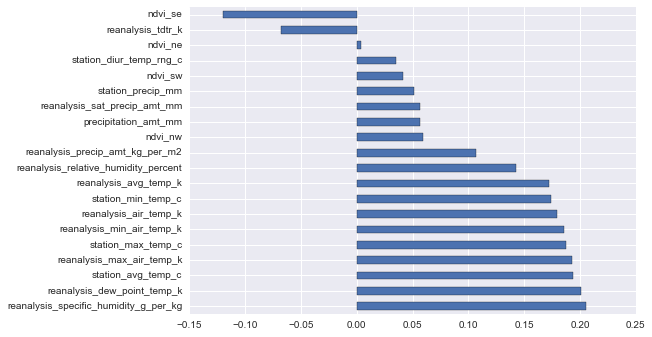

In [33]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

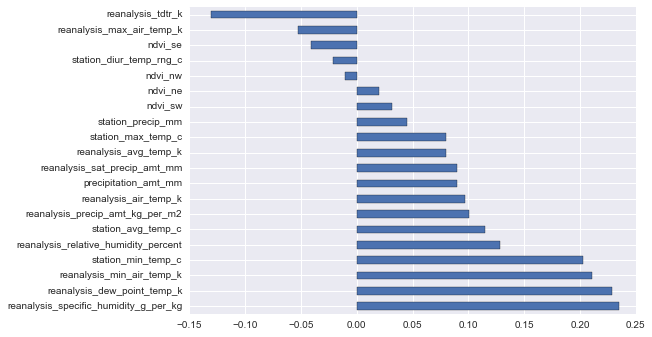

In [34]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [8]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [11]:
sj_train, iq_train = preprocess_data('dengue_features_train.csv',
                                    labels_path="dengue_labels_train.csv")

In [37]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,34.180556
std,1.560663,1.570075,1.415079,1.506281,51.381372
min,11.715714,289.642857,22.842857,17.800000,0.000000
25%,15.233571,293.843929,25.842857,21.700000,9.000000
50%,16.835000,295.451429,27.214286,22.800000,19.000000
75%,17.854286,296.415714,28.175000,23.900000,37.000000
max,19.440000,297.795714,30.071429,25.600000,461.000000


In [38]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,7.565385
std,1.443048,1.414360,0.908973,1.257734,10.765478
min,12.111429,290.088571,21.400000,14.700000,0.000000
25%,16.121429,294.596429,26.957500,20.600000,1.000000
50%,17.428571,295.852143,27.587500,21.400000,5.000000
75%,18.180357,296.557143,28.075000,22.000000,9.000000
max,20.461429,298.450000,30.800000,24.200000,116.000000


In [12]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [41]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.0808823529
best alpha =  1e-08
best score =  6.46666666667


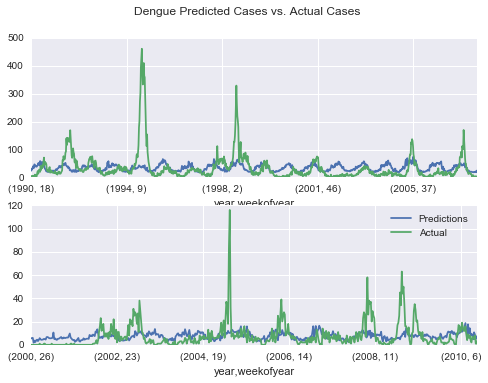

In [45]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [48]:
sj_test, iq_test = preprocess_data('dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

### lasso - did not work well

In [80]:
def preprocess_data_all(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
     'ndvi_sw',
     'precipitation_amt_mm',
     'reanalysis_air_temp_k',
     'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'reanalysis_relative_humidity_percent',
     'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
     'station_max_temp_c',
     'station_min_temp_c',
     'station_precip_mm']
   
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [81]:
sj_train, iq_train = preprocess_data_all('dengue_features_train.csv',
                                    labels_path="dengue_labels_train.csv")

In [82]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [83]:
sj_labels_subtrain=sj_train_subtrain.pop('total_cases')
sj_labels_subtest=sj_train_subtest.pop('total_cases')

In [3]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

In [84]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(sj_train_subtrain, sj_labels_subtrain)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [85]:
prediction = lasso.predict(sj_train_subtest)
err = prediction - sj_labels_subtest
R2 = 1-np.var(err)/np.var(sj_labels_subtest)
R2

0.04454667180084981

In [86]:
score =[]
best_score = 0
best_alpha= 0
for i in np.linspace(0,100,1000):
    lasso = Lasso(alpha=i).fit(sj_train_subtrain, sj_labels_subtrain)
    prediction = lasso.predict(sj_train_subtest)
    err = prediction - sj_labels_subtest
    score = 1-np.var(err)/np.var(sj_labels_subtest)
    
    
    if score > best_score:
        best_alpha = i
        best_score = score

print('best alpha = ', best_alpha)
print('best score = ', best_score)

best alpha =  0.800800800801
best score =  0.18842956742867356


In [88]:
lasso.coef_

array([-0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.08044622,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [65]:
sj_preds = lasso.predict(sj_test)
iq_preds = lasso.predict(iq_test)

In [58]:
sj_test, iq_test = preprocess_data('dengue_features_test.csv')

In [63]:
sj_preds = lasso.predict(sj_test)
iq_preds = lasso.predict(iq_test)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_preds, iq_preds])


In [67]:
submission['total_cases']=submission['total_cases'].astype(int)

In [69]:
submission.to_csv("lasso.csv")

In [93]:
feats =list(sj_train)

In [102]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.grid_search import GridSearchCV

In [ ]:
max_features : int, float, string or None, optional (default=None)
The number of features to consider when looking for the best split:
If int, then consider max_features features at each split.
If float, then max_features is a percentage and int(max_features * n_features) features are considered at each split.
If “auto”, then max_features=n_features.
If “sqrt”, then max_features=sqrt(n_features).
If “log2”, then max_features=log2(n_features).
If None, then max_features=n_features.

In [ ]:
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }


In [112]:


x = sj_train[feats[:-1]]
y = sj_train['total_cases']


parameters = {"min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              'max_features': ["auto", "sqrt", "log2"]
             
             }


clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=4)
clf.fit(x,y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

-0.1884587233273149 {'min_samples_split': 10, 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 20, 'min_samples_leaf': 10}


In [149]:
importances=tree_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.886145)
2. feature 7 (0.087584)
3. feature 5 (0.017929)
4. feature 2 (0.003757)
5. feature 0 (0.003011)
6. feature 11 (0.001574)
7. feature 8 (0.000000)
8. feature 3 (0.000000)
9. feature 4 (0.000000)
10. feature 6 (0.000000)
11. feature 19 (0.000000)
12. feature 18 (0.000000)
13. feature 10 (0.000000)
14. feature 12 (0.000000)
15. feature 13 (0.000000)
16. feature 14 (0.000000)
17. feature 15 (0.000000)
18. feature 16 (0.000000)
19. feature 17 (0.000000)
20. feature 9 (0.000000)


In [158]:
feature_names = x.columns


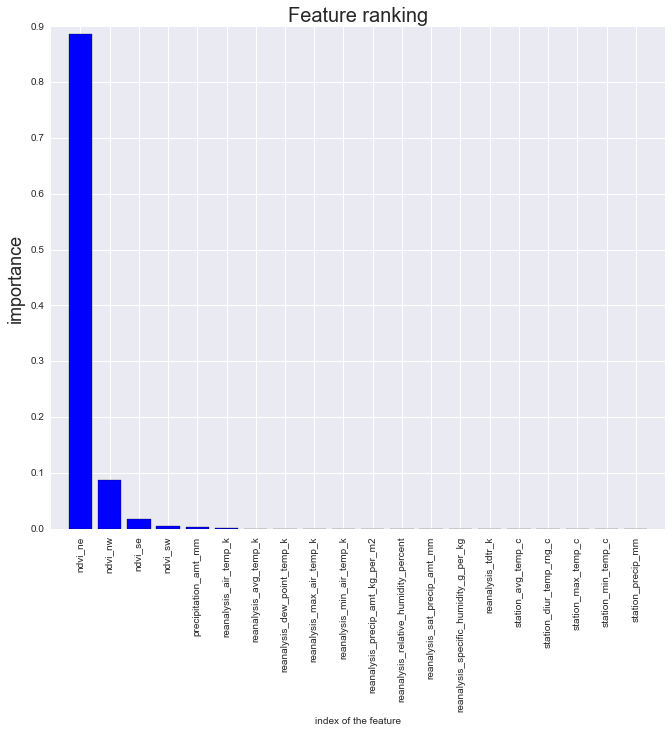

In [163]:
feature_names = x.columns

f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(x.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(x.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, x.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 10)

In [121]:
test=pd.read_csv('dengue_features_test.csv')
test.fillna(method='ffill', inplace=True)

In [122]:
preds = tree_model.predict(test[features])

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])
submission.total_cases = np.concatenate([preds])

In [119]:
features = ['ndvi_ne',
     'ndvi_nw',
     'ndvi_se',
     'ndvi_sw',
     'precipitation_amt_mm',
     'reanalysis_air_temp_k',
     'reanalysis_avg_temp_k',
     'reanalysis_dew_point_temp_k',
     'reanalysis_max_air_temp_k',
     'reanalysis_min_air_temp_k',
     'reanalysis_precip_amt_kg_per_m2',
     'reanalysis_relative_humidity_percent',
     'reanalysis_sat_precip_amt_mm',
     'reanalysis_specific_humidity_g_per_kg',
     'reanalysis_tdtr_k',
     'station_avg_temp_c',
     'station_diur_temp_rng_c',
     'station_max_temp_c',
     'station_min_temp_c',
     'station_precip_mm']

In [125]:
submission['total_cases']=submission['total_cases'].astype(int)
#submission

In [126]:
submission.to_csv("submissions/dtr2.csv")